In [2]:
!pip install tensorflow 

### Importing--
### 1) Tensorflow
### 2) Matplotlib.pyplot

In [30]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [31]:
Image_size=256
Batch_size= 32
Channels=3
Epochs=50

#### Image data preprocessing-
##### Calling image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of images from the subdirectories class_a and class_b, together with labels 0 and 1 (0 corresponding to class_a and 1 corresponding to class_b).Supported image formats: jpeg, png, bmp, gif. Animated gifs are truncated to the first frame.

In [32]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
     shuffle =True,
     image_size=(Image_size,Image_size),
     batch_size=Batch_size
    )

Found 2153 files belonging to 3 classes.


In [33]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [34]:
len(dataset)

68

##### Its actual length is 68*32 because 32 is thee batch size

#### Representing the data visually 
##### For easier understanding we take first 10 images of different classes

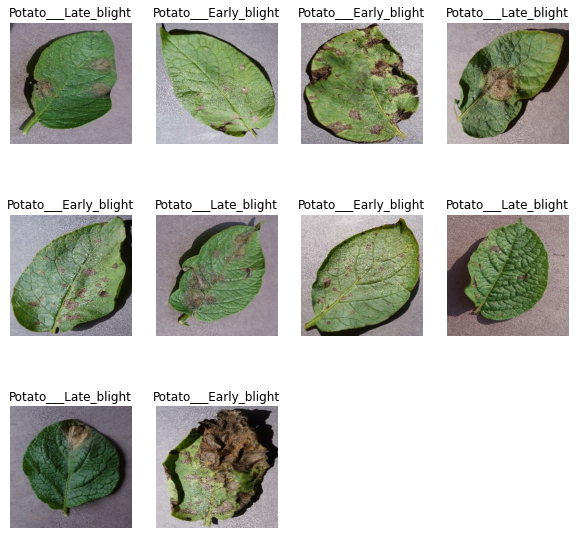

In [35]:
plt.figure(figsize=(10,10)) #increasing area so that the images are displayed clearly
for image_batch,label_batch in dataset.take(1):
    for i in range(10):
        ax= plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [36]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

##### Splitting the data into train_set, validation_set,test_dataset

In [37]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [38]:
print(len(train_ds),len(val_ds),len(test_ds))

54 6 8


#### Caching and prefetching
##### Cache prefetching is a technique used by computer processors to boost execution performance by fetching instructions or data from their original storage in slower memory to a faster local memory before it is actually needed ,here we use tensorflows .cache() method to cache and .prefetch() to prefetch

In [39]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds =val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds =test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

##### Now our datasets are optimized for training performance hence our training will run fast

### Preprocessing
#### 1) Resize and Rescale- 
##### this takes care of the images that are not 256 X 256 and helps in reducing error
#### 2) Data Augmentation-
##### this is used to generate more samples from lesser ones by rotating,flipping or by taking the mirror image of an already existing data

In [40]:
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_size,Image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [41]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

### Model Building
##### Main idea behind CNN is feature extraction
##### We use CNN in image processing because of its high accuracy. The CNN follows a hierarchical model which works on building a network, like a funnel, and finally gives out a fully-connected layer where all the neurons are connected to each other and the output is processed.

In [42]:
input_shape=(Batch_size,Image_size,Image_size,Channels)
n_classes=3

In [43]:
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation="relu",input_shape=input_shape),
    ##filter=32(matrix types)
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(n_classes,activation="softmax"),
])
model.build(input_shape=input_shape)

In [44]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_5 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [49]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

history=model.fit(
    train_ds,
    epochs=Epochs,
    batch_size=Batch_size,
    # steps_per_epoch=1000
    verbose=1,
    validation_data=val_ds
)

In [60]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 2s 288ms/step - loss: 0.0116 - accuracy: 0.9922


In [61]:
scores

[0.01155606284737587, 0.9921875]

In [62]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [63]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history['loss']
val_loss=history.history['val_loss']

###### We can change the parameters and build the network with high number of iterations and higher number of layers to yield better results. This will depend on the computational power of our system.

Text(0.5, 1.0, 'Training and Validation loss')

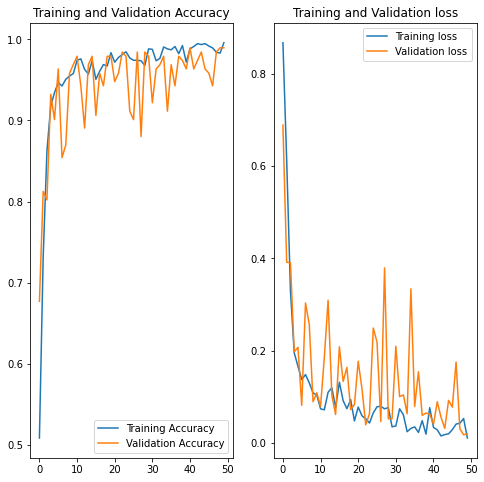

In [65]:
#Accuracy plot
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(Epochs),acc, label="Training Accuracy")
plt.plot(range(Epochs),val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
#Loss plot
plt.subplot(1,2,2)
plt.plot(range(Epochs),loss, label="Training loss")
plt.plot(range(Epochs),val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training and Validation loss")

### Run Prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 531ms/step
predivted label: Potato___Late_blight


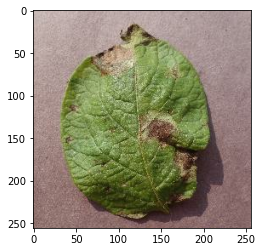

In [66]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):# randomly shuffling images
    first_image=images_batch[0].numpy().astype("uint8")
    first_label=labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    batch_prediction=model.predict(images_batch)
    print("predivted label:",class_names[np.argmax(batch_prediction[0])])

### Function for inference 

In [72]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

##### Now we run inference on few examples

1/1 [==============================] - 0s 40ms/step


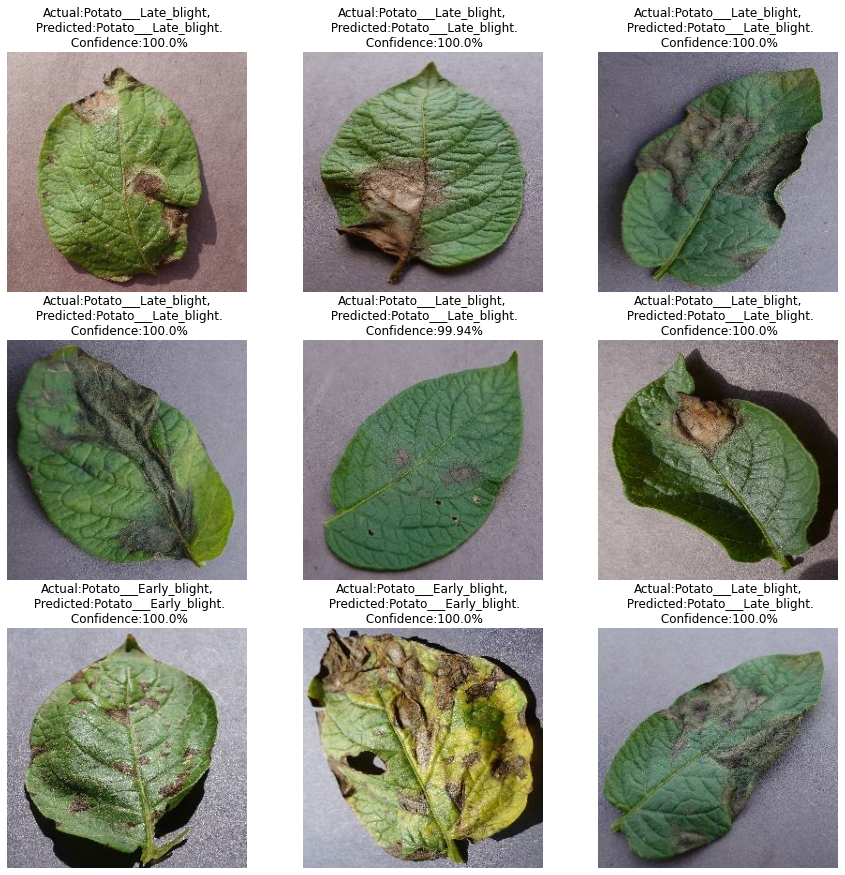

In [73]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    #lets test on 9 examples
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class}.\n Confidence:{confidence}%")
        plt.axis("off")

### Saving the model
#### We append the model to the list of models as a new version

In [85]:
import os
model_version=max([int(i) for i in os.listdir("/models")+[0]])+1
model.save(f"/models/{model_version}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/models'

In [86]:
model.save("../potatoes.h5")